Imports

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import os

import pickle
import random

import pandas as pd
import matplotlib.pyplot as plt

from src.network_distance import ge, _ge_Q
from src.network_analysis import compute_generalized_euclidean_matrix, prepare_category_dicts, compute_livability_from_matrix, compute_livability_normalized_average, normalize_ge_sum_to_one, normalize_ge_rowwise, add_inv_degree_weights, compute_z_scores

Methods

In [2]:
# Return the largest connected component of a graph as a subgraph
def get_largest_component(G):
    largest_nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_nodes).copy()

In [ ]:
# Precompute graphs, Q, GE, and z-scores
def precompute_data(n_values, density_factor, categories):
    data = {}
    precomputed_path = "test_results/precomputed_data.pkl"

    # Load from disk if already exists
    if os.path.exists(precomputed_path):
        with open(precomputed_path, "rb") as f:
            data = pickle.load(f)
        print("Loaded precomputed graphs")
        return data

    os.makedirs("test_results", exist_ok=True)

    for n in n_values:
        # Create random graph
        G = nx.gnm_random_graph(n, int(density_factor * n))
        G = get_largest_component(G)
        Q = _ge_Q(G)

        # Weighted version (add inverse degree weights)
        G_weighted = add_inv_degree_weights(G.copy())
        Q_weighted = _ge_Q(G_weighted)

        print(f"n={n}, nodes={G.number_of_nodes()}, edges={G.number_of_edges()}, connected={nx.is_connected(G)}")

        data[n] = {
            "G": G,
            "Q": Q,
            "G_weighted": G_weighted,
            "Q_weighted": Q_weighted,
        }


    # Save
    with open(precomputed_path, "wb") as f:
        pickle.dump(data, f)
        
    print("Saved precomputed graphs.")

    return data

In [4]:
# Create a synthetic 'category_counts' DataFrame
# Columns: block_id | category | count
def make_synthetic_category_counts(G, categories, poi_mean=4):
    rows = []
    all_blocks = list(G.nodes())

    for cat in categories:
        for block_id in all_blocks:

            # Normal distribution (can be different)
            count = int(max(np.random.normal(poi_mean, poi_mean/2), 0))
            rows.append({"block_id": block_id, "category": cat, "count": count})

    return pd.DataFrame(rows)

In [ ]:
# Methods for computing livability using methods from the main code
def compute_livability(df_ge, z_scores, method="unnormalized", G=None, categories=None, Q=None):

    if method == "unnormalized":
        return compute_livability_from_matrix(df_ge, z_scores)

    elif method == "average":
        return compute_livability_normalized_average(df_ge, z_scores)

    elif method == "ge_normalized_total":
        df_ge_sum1 = normalize_ge_sum_to_one(df_ge)
        return compute_livability_from_matrix(df_ge_sum1, z_scores)

    elif method == "ge_normalized_rowwise":
        df_ge_row = normalize_ge_rowwise(df_ge)
        return compute_livability_from_matrix(df_ge_row, z_scores)
    
    elif method == "log_ge":
        GE = df_ge.values.astype(float)
        GE[GE <= 0] = 1e-9
        GE_log = np.log(GE)
        df_ge_log = pd.DataFrame(GE_log, index=df_ge.index, columns=df_ge.columns)
        return compute_livability_from_matrix(df_ge_log, z_scores)

    elif method == "weighted_graph":
        df_ge_weighted = compute_generalized_euclidean_matrix(
            G, categories, ge_func=ge, Q_func=lambda _: Q)

        return compute_livability_from_matrix(df_ge_weighted, z_scores)

    else:
        raise ValueError(f"Unknown method")

In [ ]:
# Run livability tests for multiple graph sizes (n_values) and number of POIs per block (poi_values),
# to compare several normalization methods on the same data
def run_livability_tests(iterations=10, save_every=20, output_dir="test_results"):

    # Settings for tests
    n_values = [100, 200, 400, 800, 1600]
    poi_values = [1, 2, 4, 8, 16]
    density_factor = 2.5

    categories = [
        "food", "infrastructure_transport", "education", "culture_leisure",
        "public_services", "healthcare", "retail", "green_spaces", "other_daily_utilities"
    ]
    methods = ["unnormalized", "average", "ge_normalized_total", "ge_normalized_rowwise", "log_ge", "weighted_graph"]

    # Prepare output directory and resutlt file
    os.makedirs(output_dir, exist_ok=True)
    out_file = os.path.join(output_dir, "livability_results.csv")
    file_exists = os.path.exists(out_file)
    base_seed = 42

    # Load already completed progress
    if file_exists:
        df_done = pd.read_csv(out_file)
        print(f"Resuming from {len(df_done)} existing results...")
    else:
        df_done = pd.DataFrame(columns=["n_nodes", "poi_mean", "method", "iteration"])

    print("Precomputing graphs...")
    data = precompute_data(n_values, density_factor, categories)

    results = []

    # Main testing
    for n in n_values:
        G = data[n]["G"]
        Q = data[n]["Q"]
        G_weighted = data[n]["G_weighted"]
        Q_weighted = data[n]["Q_weighted"]

        for poi_mean in poi_values:

            # Find completed iterations for this (n, poi_mean)
            done_iters = set(
                df_done[
                    (df_done["n_nodes"] == n) & (df_done["poi_mean"] == poi_mean)
                ]["iteration"].unique()
            )

            for i in range(iterations):
                iter_id = i + 1

                # Skip if this iteration already computed in previous run
                if iter_id in done_iters:
                    continue

                # Generate synthetic POI data for this iteration
                category_counts = make_synthetic_category_counts(G, categories, poi_mean)
                category_dicts = prepare_category_dicts(category_counts, G)

                # ---- Unweighted graph ----
                # GE matrix for unweighted graph
                df_ge_unweighted = compute_generalized_euclidean_matrix(G, category_dicts, ge_func=ge, Q_func=lambda _: Q)

                # Compute z-scores
                seed_unweighted = base_seed + n * 100_000 + poi_mean * 1_000 + iter_id
                np.random.seed(seed_unweighted)
                random.seed(seed_unweighted)

                df_z_unweighted = compute_z_scores(category_dicts, G, Q, n_iter=100)

                # Extract z-scores
                z_scores_unweighted = df_z_unweighted.loc[df_ge_unweighted.index, "z_score"].values

                # ---- Weighted graph ----
                # GE matrix for weighted graph
                df_ge_weighted = compute_generalized_euclidean_matrix(G_weighted, category_dicts, ge_func=ge, Q_func=lambda _: Q_weighted)

                # Compute z-scores for weighted graph
                seed_weighted = seed_unweighted + 1
                np.random.seed(seed_weighted)
                random.seed(seed_weighted)

                df_z_weighted = compute_z_scores(category_dicts, G_weighted, Q_weighted, n_iter=100)

                # Extract z-scores
                z_scores_weighted = df_z_weighted.loc[df_ge_weighted.index, "z_score"].values

                # ---- Evaluate all methods ----
                for method in methods:
                    
                    # Unweighted methods share same GE and z-scores
                    if method != "weighted_graph":
                        score = compute_livability(df_ge_unweighted, z_scores_unweighted, method=method, 
                                                   G=G, categories=category_dicts, Q=Q)
                    else:
                        score = compute_livability(df_ge_weighted, z_scores_weighted, method=method,
                                                   G=G_weighted, categories=category_dicts, Q=Q_weighted)

                    results.append({
                        "n_nodes": n,
                        "poi_mean": poi_mean,
                        "method": method,
                        "iteration": i + 1,
                        "score": score
                    })

                # Write results every `save_every` iteriations
                if iter_id  % save_every == 0:
                    df_partial = pd.DataFrame(results)
                    df_partial.to_csv(out_file, mode="a", header=not file_exists, index=False)
                    file_exists = True

                    results = []

                    print(f"Saved partial results at iteration {i+1}/{iterations} for n={n}, poi_mean={poi_mean}")


            # After finishing all iterations for this poi_mean
            if results:
                df_partial = pd.DataFrame(results)
                df_partial.to_csv(out_file, mode="a",
                                header=not os.path.exists(out_file),
                                index=False)
                results = []

                print(f"Saved final results for n={n}, poi_mean={poi_mean}")


            print(f"Completed n={n}, poi_mean={poi_mean}")

    # Load all results and compute summary statistics
    df = pd.read_csv(out_file)

    # mean and std of score for each (n, poi_mean, method)
    df_summary = df.groupby(["n_nodes", "poi_mean", "method"]).agg(["mean", "std"]).reset_index()

    return df, df_summary


In [7]:
df, df_summary = run_livability_tests(iterations=10000, save_every=100)

Resuming from 1500000 existing results...
Precomputing graphs...
Loaded precomputed graphs
Completed n=100, poi_mean=1
Completed n=100, poi_mean=2
Completed n=100, poi_mean=4
Completed n=100, poi_mean=8
Completed n=100, poi_mean=16
Completed n=200, poi_mean=1
Completed n=200, poi_mean=2
Completed n=200, poi_mean=4
Completed n=200, poi_mean=8
Completed n=200, poi_mean=16
Completed n=400, poi_mean=1
Completed n=400, poi_mean=2
Completed n=400, poi_mean=4
Completed n=400, poi_mean=8
Completed n=400, poi_mean=16
Completed n=800, poi_mean=1
Completed n=800, poi_mean=2
Completed n=800, poi_mean=4
Completed n=800, poi_mean=8
Completed n=800, poi_mean=16
Completed n=1600, poi_mean=1
Completed n=1600, poi_mean=2
Completed n=1600, poi_mean=4
Completed n=1600, poi_mean=8
Completed n=1600, poi_mean=16


In [8]:
# Load the raw results (each row = one iteration)
df = pd.read_csv("test_results/livability_results.csv")
print(df.head())

   n_nodes  poi_mean                 method  iteration      score
0      100         1           unnormalized          1   0.285221
1      100         1                average          1  20.535879
2      100         1    ge_normalized_total          1   1.769703
3      100         1  ge_normalized_rowwise          1   0.195134
4      100         1                 log_ge          1  -0.004825


In [9]:
# Group by the parameters to summarize iterations
df_summary = (
    df.groupby(["n_nodes", "poi_mean", "method"])
      ["score"]
      .agg(["mean", "std"])
      .reset_index()
)

print(df_summary.head())

   n_nodes  poi_mean                 method       mean       std
0      100         1                average  16.428225  4.892599
1      100         1  ge_normalized_rowwise   0.149817  0.043459
2      100         1    ge_normalized_total   1.344664  0.393361
3      100         1                 log_ge  -0.003677  0.001064
4      100         1           unnormalized   0.228170  0.067953


In [10]:
# Method labels for plots
method_labels = {
    "unnormalized": "Unnormalized",
    "average": "Average",
    "ge_normalized_total": "GE normalized (total sum = 1)",
    "ge_normalized_rowwise": "GE normalized (row-wise)",
    "log_ge": "Logarithmic GE",
    "weighted_graph": "Weighted graph"
}

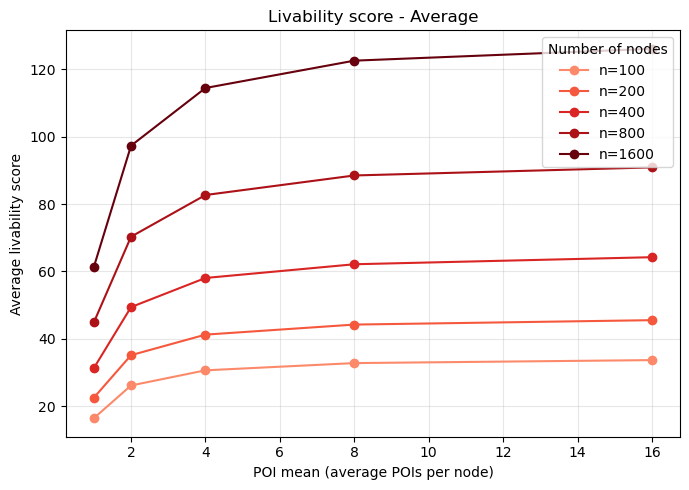

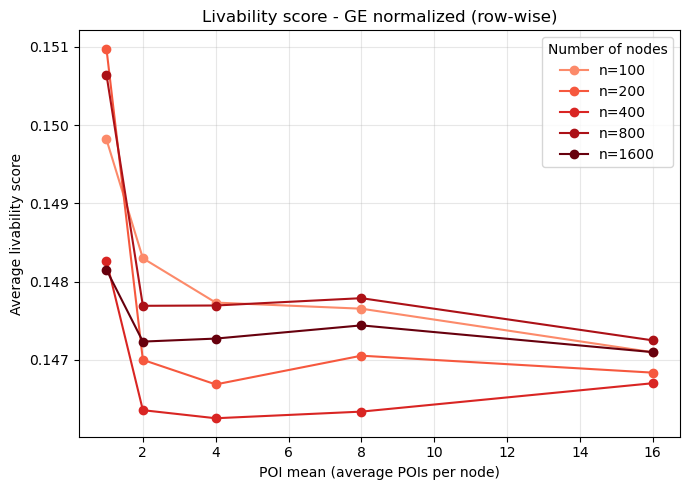

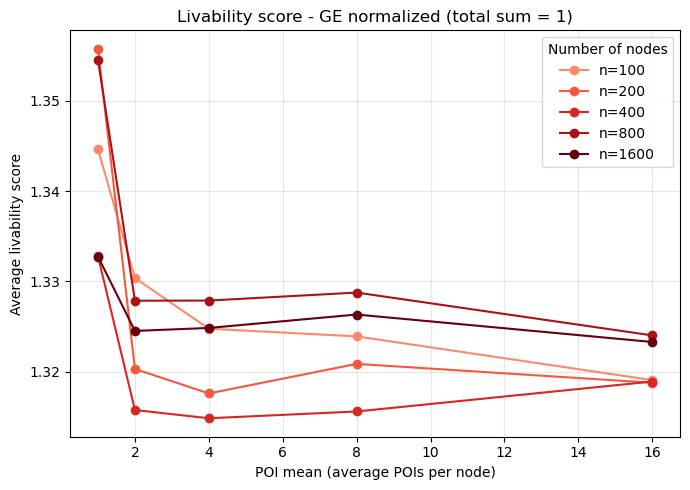

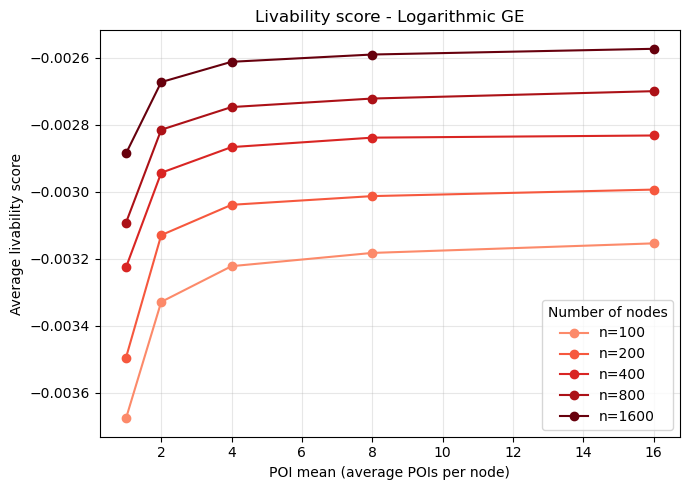

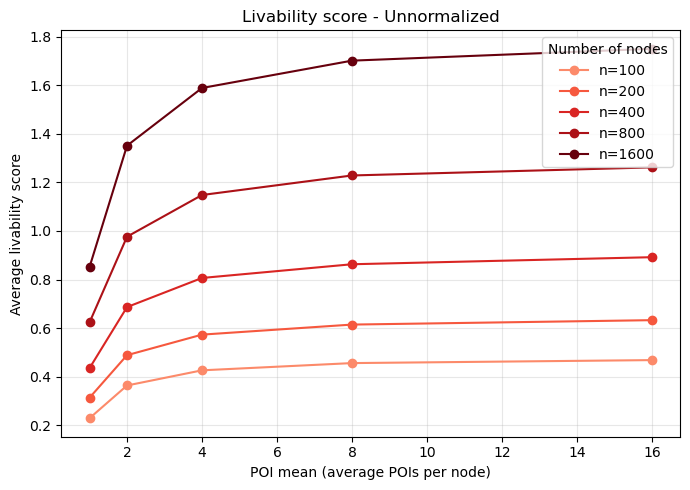

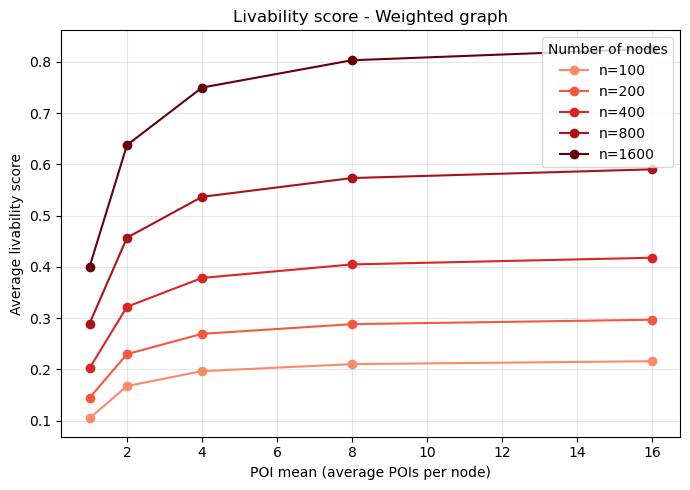

In [11]:
# Sort for plotting
df_summary = df_summary.sort_values(["method", "n_nodes", "poi_mean"])

# Create color scale for graph size (light red to dark red)
n_unique = sorted(df_summary["n_nodes"].unique())
colors = plt.cm.Reds(np.linspace(0.4, 1.0, len(n_unique)))

# One plot per normalization method
for method in df_summary["method"].unique():
    subset = df_summary[df_summary["method"] == method]
    plt.figure(figsize=(7,5))

    for color, n in zip(colors, n_unique):
        s = subset[subset["n_nodes"] == n]
        plt.plot(
            s["poi_mean"], s["mean"], 
            marker="o", color=color, label=f"n={n}"
        )

    plt.title(
        f"Livability score - {method_labels[method]}",
        fontsize=12
    )
    plt.xlabel("POI mean (average POIs per node)", fontsize=10)
    plt.ylabel("Average livability score", fontsize=10)
    plt.legend(title="Number of nodes", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(f"test_results/livability_{method}.pdf", dpi=300)

    plt.show()
